<a href="https://colab.research.google.com/github/jazzlynamelia/pneumonia-detection/blob/main/Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# Hapus file & folder di content colab (biar ga duplicate)
!rm -rf /content/*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import json
import pickle
import joblib
import warnings
import sys
import tracemalloc

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    InputLayer,
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Uji statistik
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2

# Visualization
import seaborn as sns

warnings.filterwarnings('ignore')

# Constants

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
CHANNELS = 3
SEED = 42

# Import Stratified Split Dataset

In [ ]:
SPLIT_DIR = "/content/drive/MyDrive/ResearchMethod/split_dataset_binary"

train_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'train'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'val'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'test'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 3700 files belonging to 2 classes.
Found 463 files belonging to 2 classes.
Found 463 files belonging to 2 classes.
Class names: ['normal', 'pneumonia']


In [ ]:
import numpy as np

def count_labels_in_dataset(dataset, class_names):
    class_counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Hitung jumlah per kelas
print("Distribusi kelas di Train:")
print(count_labels_in_dataset(train_ds, class_names))

print("Distribusi kelas di Val:")
print(count_labels_in_dataset(val_ds, class_names))

print("Distribusi kelas di Test:")
print(count_labels_in_dataset(test_ds, class_names))

Distribusi kelas di Train:
{'normal': 1850, 'pneumonia': 1850}
Distribusi kelas di Val:
{'normal': 231, 'pneumonia': 232}
Distribusi kelas di Test:
{'normal': 232, 'pneumonia': 231}


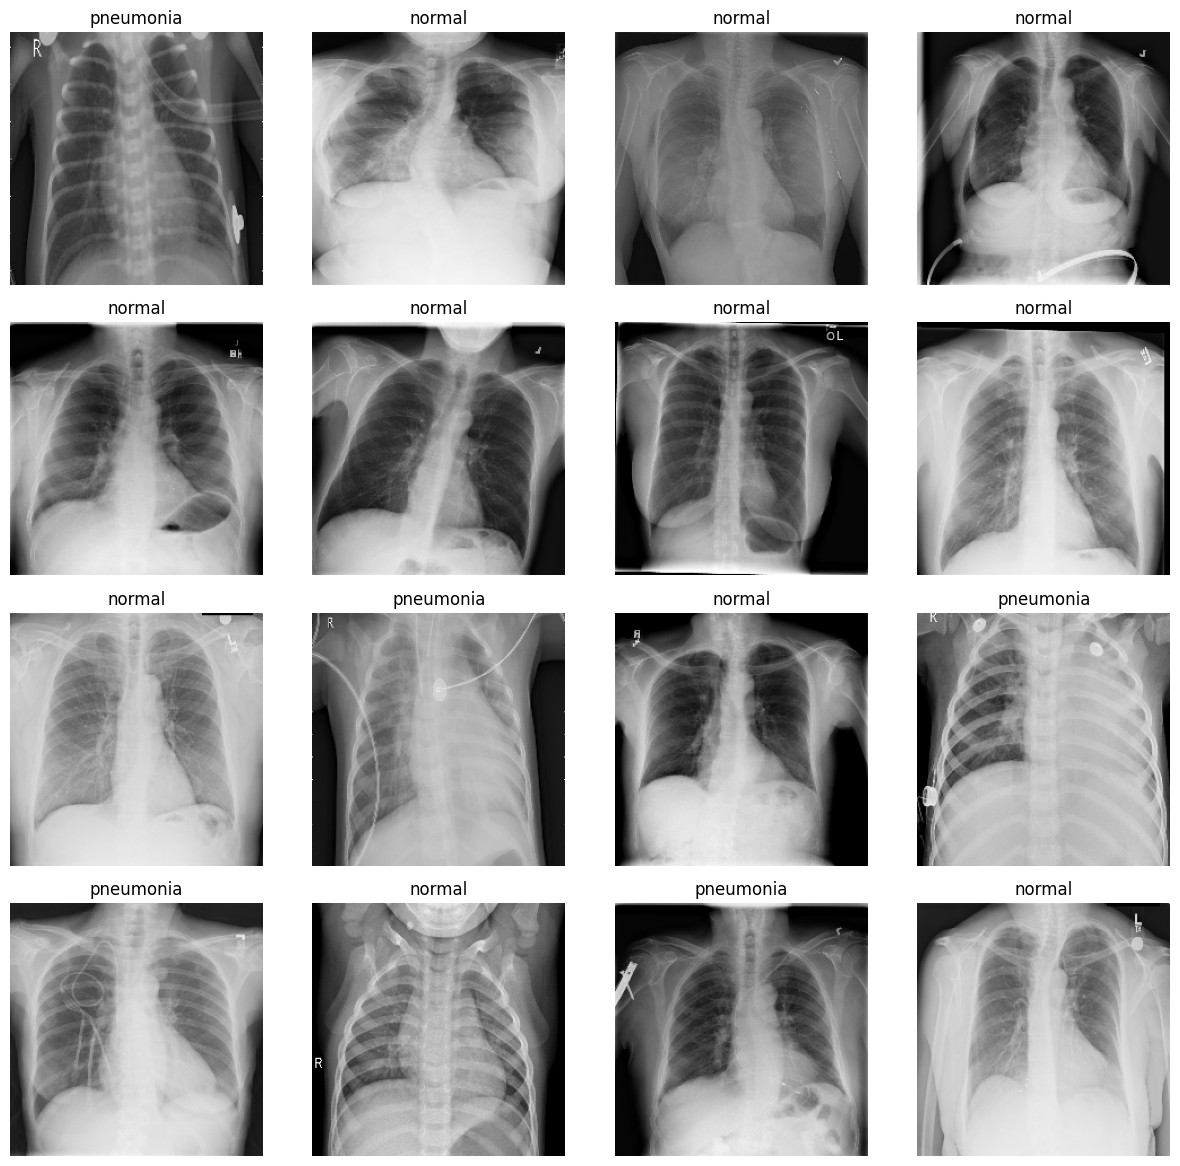

In [ ]:
# Visualisasi image
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")

# Preprocessing + Augmentation

In [ ]:
# Preprocessing Layer (resizing + rescaling)
preprocess_layer = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [ ]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1),
])

In [ ]:
# Apply preprocessing + augmentation to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(preprocess_layer(x), training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Apply preprocessing only to val & test sets
val_ds = val_ds.map(lambda x, y: (preprocess_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_layer(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN (DenseNet201) End-to-End

In [ ]:
# Tentukan path untuk menyimpan hasil
SAVE_DIR_CNN = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_EndToEnd_CPU"
if not os.path.exists(SAVE_DIR_CNN):
    os.makedirs(SAVE_DIR_CNN)

MODEL_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_end_to_end_model.h5")
RESULTS_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_end_to_end_results.csv")
PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_training_curves.png")
ROC_PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_roc_curve.png")
CM_PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_confusion_matrix.png")

## Define Model DenseNet201

In [ ]:
# Load pre-trained base model
base_model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

# Unfreeze beberapa layer terakhir dari base model untuk fine-tuning
base_model.trainable = True
fine_tune_at = -50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Membuat model baru di atas base model
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x) # Output layer dengan sigmoid untuk klasifikasi biner

densenet_model = Model(inputs, outputs)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
densenet_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

densenet_model.summary()
print(f"\nTotal Trainable Parameters: {sum([w.shape.num_elements() for w in densenet_model.trainable_weights])}")

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,814,017 (71.77 MB)

 Trainable params: 2,383,041 (9.09 MB)

 Non-trainable params: 16,430,976 (62.68 MB)


Total Trainable Parameters: 2383041


## Training Model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Mulai ukur waktu & memori
start_time = time.time()
tracemalloc.start()

history_densenet = densenet_model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

# Hentikan pengukuran
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"\nTraining Selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak / 10**6:.2f} MB")

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1333s 40s/step - accuracy: 0.4971 - loss: 0.7751 - val_accuracy: 0.5486 - val_loss: 0.6820
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1035s 35s/step - accuracy: 0.5112 - loss: 0.7409 - val_accuracy: 0.6199 - val_loss: 0.6383
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1077s 37s/step - accuracy: 0.5189 - loss: 0.7265 - val_accuracy: 0.6868 - val_loss: 0.6010
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1145s 39s/step - accuracy: 0.5225 - loss: 0.7239 - val_accuracy: 0.7495 - val_loss: 0.5602
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1143s 39s/step - accuracy: 0.5141 - loss: 0.7179 - val_accuracy: 0.7927 - val_loss: 0.5230
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1166s 39s/step - accuracy: 0.5492 - loss: 0.6986 - val_accuracy: 0.8186 - val_loss: 0.4937
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1162s 40s/step - accuracy: 0.5500 - loss: 0.6886 - val_accuracy: 0.8229 - val_loss: 0.4777
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1099s 38s/step - accuracy: 0.5469 - loss: 0.6954 - val_accu

## Model Evaluation

In [ ]:
print("\n--- Mengevaluasi Model pada Test Set ---")

# Ekstrak label asli dari test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Prediksi probabilitas
y_pred_proba = densenet_model.predict(test_ds)

# Ubah probabilitas menjadi kelas (0 atau 1) dengan threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Hitung metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


--- Mengevaluasi Model pada Test Set ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 111s 24s/step
Accuracy: 0.8143
Precision: 0.8796
Recall: 0.7273
F1-Score: 0.7962
AUC: 0.9114

Classification Report:
               precision    recall  f1-score   support

      normal       0.77      0.90      0.83       232
   pneumonia       0.88      0.73      0.80       231

    accuracy                           0.81       463
   macro avg       0.82      0.81      0.81       463
weighted avg       0.82      0.81      0.81       463



In [ ]:
# Simpan metrik ke dalam dictionary
densenet_results = {
    "model": "DenseNet201_EndToEnd",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": auc,
    "training_time_seconds": training_time,
    "peak_memory_mb": peak / 10**6,
    "trainable_params": sum([w.shape.num_elements() for w in densenet_model.trainable_weights])
}

# Simpan dictionary metrik ke file CSV di Google Drive
df_results = pd.DataFrame([densenet_results])
df_results.to_csv(RESULTS_PATH_CNN, index=False)
print(f"\nMetrik evaluasi berhasil disimpan di: {RESULTS_PATH_CNN}")

# Simpan model terlatih ke Google Drive
densenet_model.save(MODEL_PATH_CNN)
print(f"Model berhasil disimpan di: {MODEL_PATH_CNN}")

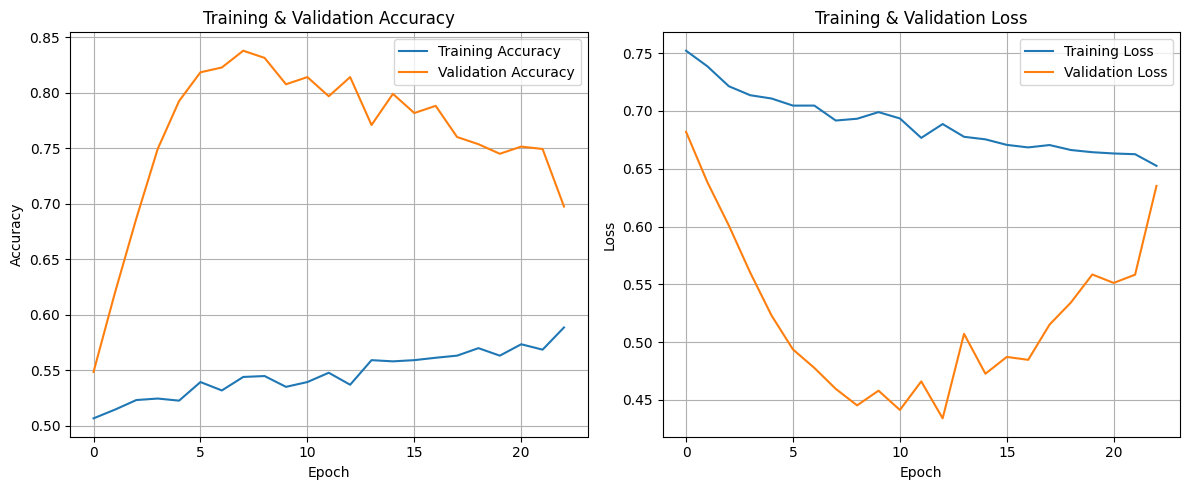

Grafik training berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_EndToEnd_CPU/densenet201_training_curves.png


In [ ]:
# Grafik Training & Validation Loss/Accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(PLOT_PATH_CNN)
plt.show()
print(f"Grafik training berhasil disimpan di: {PLOT_PATH_CNN}")

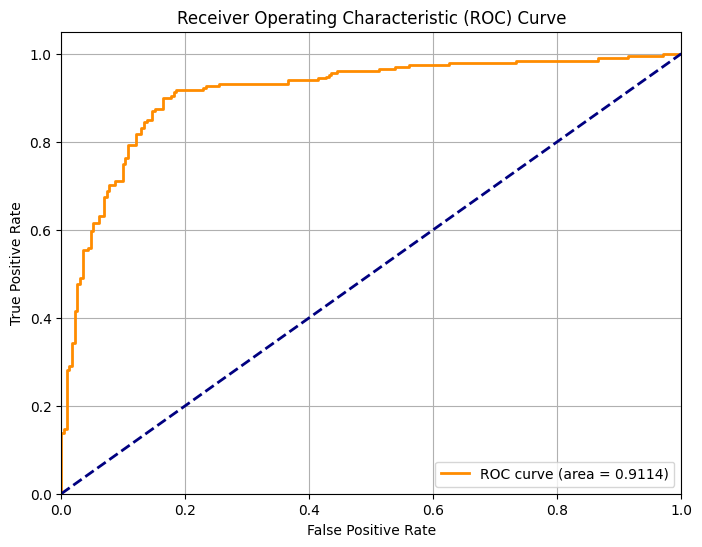

Grafik ROC Curve berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_EndToEnd_CPU/densenet201_roc_curve.png


In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(ROC_PLOT_PATH_CNN) # Simpan grafik ROC ke PNG
plt.show()
print(f"Grafik ROC Curve berhasil disimpan di: {ROC_PLOT_PATH_CNN}")

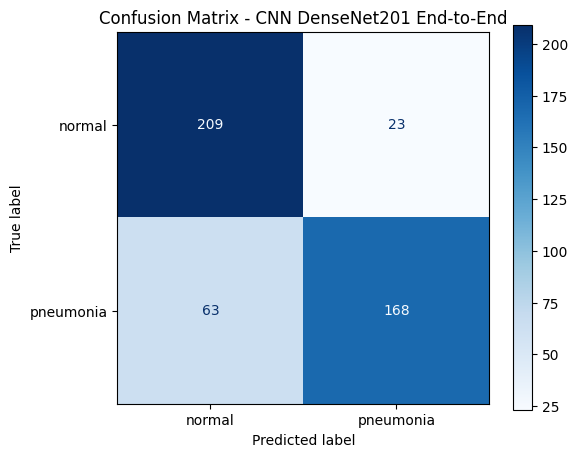

Plot Confusion Matrix berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_EndToEnd_CPU/densenet201_confusion_matrix.png


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix - CNN DenseNet201 End-to-End')
ax.grid(False)
plt.savefig(CM_PLOT_PATH_CNN)
plt.show()
print(f"Plot Confusion Matrix berhasil disimpan di: {CM_PLOT_PATH_CNN}")